##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Russian into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translateru_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms.

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.6 MB/s eta 0:00:00


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import collections
import os
import pathlib
import re
import string
import sys
import tempfile



## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Russian-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translateru_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/208106 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete98WWHZ/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/4805 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete98WWHZ/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/5476 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete98WWHZ/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Russian:')
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Russian:
к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

> Examples in English:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Russian) for **this dataset** and exports them in a TensorFlow `saved_model` format.

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.



In [6]:
tf.get_logger().setLevel('ERROR')
pwd = pathlib.Path.cwd()

In [7]:
train_en = train_examples.map(lambda run, en: en)
train_ru = train_examples.map(lambda ru, en: ru)

## Generate the vocabulary

This section generates a wordpiece vocabulary from a dataset. If you already have a vocabulary file and just want to see how to build a `text.BertTokenizer` or `text.WordpieceTokenizer` tokenizer with it then you can skip ahead to the [Build the tokenizer](#build_the_tokenizer) section.

Note: The vocabulary generation code used in this tutorial is optimized for simplicity. If you need a more scalable solution consider using the Apache Beam implementation available in tools/wordpiece_vocab/generate_vocab.py

The vocabulary generation code is included in the `tensorflow_text` pip package. It is not imported by default , you need to manually import it:

In [8]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

The `bert_vocab.bert_vocab_from_dataset` function will generate the vocabulary.

There are many arguments you can set to adjust its behavior. For this tutorial, you'll mostly use the defaults. If you want to learn more about the options, first read about [the algorithm](#algorithm), and then have a look at [the code](https://github.com/tensorflow/text/blob/master/tensorflow_text/tools/wordpiece_vocab/bert_vocab_from_dataset.py).


This takes about 2 minutes.

In [9]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [10]:
%%time
ru_vocab = bert_vocab.bert_vocab_from_dataset(
    train_ru.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 12min 13s, sys: 9.71 s, total: 12min 22s
Wall time: 12min 21s


Here are some slices of the resulting vocabulary.

In [11]:
print(ru_vocab[:10])
print(ru_vocab[100:110])
print(ru_vocab[1000:1010])
print(ru_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'і', '՛']
['трудно', 'хотела', 'далеко', 'качестве', 'мою', '##3', '##де', '##ила', 'планеты', 'большие']
['##’', '##“', '##”', '##„', '##•', '##′', '##⁄', '##∇', '##♪', '##♫']


Write a vocabulary file:

In [12]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [13]:
write_vocab_file('ru_vocab.txt', ru_vocab)

Use that function to generate a vocabulary from the english data:

In [14]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(1000).prefetch(2),
    **bert_vocab_args
)


CPU times: user 2min 43s, sys: 3.21 s, total: 2min 46s
Wall time: 2min 41s


In [15]:
print(en_vocab[:10])
print(en_vocab[100:110])
print(en_vocab[1000:1010])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['##s', 'have', 'but', 'what', 'on', 'do', 'with', 'can', 'there', 'about']
['revolution', '200', 'basic', 'potential', 'english', 'led', 'message', 'perfect', '##ce', 'nine']
['##–', '##—', '##‘', '##’', '##“', '##”', '##•', '##∇', '##♪', '##♫']


Here are the two vocabulary files:

In [16]:
write_vocab_file('en_vocab.txt', en_vocab)

In [17]:
!ls *.txt

en_vocab.txt  ru_vocab.txt


## Build the tokenizer
<a id="build_the_tokenizer"></a>

The `text.BertTokenizer` can be initialized by passing the vocabulary file's path as the first argument (see the section on [tf.lookup](#tf.lookup) for other options):

In [18]:
ru_tokenizer = tensorflow_text.BertTokenizer('ru_vocab.txt', **bert_tokenizer_params)
en_tokenizer = tensorflow_text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

Now you can use it to encode some text. Take a batch of 3 examples from the english data:

In [19]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy())

b'c : success , the change is only coming through the barrel of the gun .'
b'the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .'
b"( video ) didi pickles : it 's four o'clock in the morning ."


Run it through the `BertTokenizer.tokenize` method. Initially, this returns a `tf.RaggedTensor` with axes `(batch, word, word-piece)`:

In [20]:
# Tokenize the examples -> (batch, word, word-piece)
token_batch = en_tokenizer.tokenize(en_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

for ex in token_batch.to_list():
  print(ex)

[41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16]
[84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16]
[10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16]


If you replace the token IDs with their text representations (using `tf.gather`) you can see that in the first example the words `"searchability"` and  `"serendipity"` have been decomposed into `"search ##ability"` and `"s ##ere ##nd ##ip ##ity"`:

In [21]:
# Lookup each token id in the vocabulary.
txt_tokens = tf.gather(en_vocab, token_batch)
# Join with spaces.
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'c : success , the change is only coming through the barrel of the gun .',
       b'the document ##ation and the hands - on teaching method ##ology is also open - source and released as the creative commons .',
       b"( video ) did ##i pick ##les : it ' s four o ' clock in the morning ."],
      dtype=object)>

To re-assemble words from the extracted tokens, use the `BertTokenizer.detokenize` method:

In [22]:
words = en_tokenizer.detokenize(token_batch)
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'c : success , the change is only coming through the barrel of the gun .',
       b'the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .',
       b"( video ) didi pickles : it ' s four o ' clock in the morning ."],
      dtype=object)>



    Note: BertTokenizer.tokenize/BertTokenizer.detokenize does not round trip losslessly. The result of detokenize will not, in general, have the same content or offsets as the input to tokenize. This is because of the "basic tokenization" step, that splits the strings into words before applying the WordpieceTokenizer, includes irreversible steps like lower-casing and splitting on punctuation. WordpieceTokenizer on the other hand is reversible.



## Customization and export

This tutorial builds the text tokenizer and detokenizer used by the [Transformer](https://tensorflow.org/text/tutorials/transformer) tutorial. This section adds methods and processing steps to simplify that tutorial, and exports the tokenizers using `tf.saved_model` so they can be imported by the other tutorials.

### Custom tokenization

The downstream tutorials both expect the tokenized text to include `[START]` and `[END]` tokens.

The `reserved_tokens` reserve space at the beginning of the vocabulary, so `[START]` and `[END]` have the same indexes for both languages:

In [23]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [24]:
words = en_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'[START] c : success , the change is only coming through the barrel of the gun . [END]',
       b'[START] the documentation and the hands - on teaching methodology is also open - source and released as the creative commons . [END]',
       b"[START] ( video ) didi pickles : it ' s four o ' clock in the morning . [END]"],
      dtype=object)>

### Custom detokenization

Before exporting the tokenizers there are a couple of things you can cleanup for the downstream tutorials:

1. They want to generate clean text output, so drop reserved tokens like `[START]`, `[END]` and `[PAD]`.
2. They're interested in complete strings, so apply a string join along the `words` axis of the result.  

In [25]:
def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [26]:
en_examples.numpy()

array([b'c : success , the change is only coming through the barrel of the gun .',
       b'the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .',
       b"( video ) didi pickles : it 's four o'clock in the morning ."],
      dtype=object)

In [27]:
token_batch = en_tokenizer.tokenize(en_examples).merge_dims(-2,-1)
words = en_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'c', b':', b'success', b',', b'the', b'change', b'is', b'only',
  b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun', b'.'],
 [b'the', b'documentation', b'and', b'the', b'hands', b'-', b'on',
  b'teaching', b'methodology', b'is', b'also', b'open', b'-', b'source',
  b'and', b'released', b'as', b'the', b'creative', b'commons', b'.']    ,
 [b'(', b'video', b')', b'didi', b'pickles', b':', b'it', b"'", b's',
  b'four', b'o', b"'", b'clock', b'in', b'the', b'morning', b'.']    ]>

In [28]:
cleanup_text(reserved_tokens, words).numpy()

array([b'c : success , the change is only coming through the barrel of the gun .',
       b'the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .',
       b"( video ) didi pickles : it ' s four o ' clock in the morning ."],
      dtype=object)

### Export

The following code block builds a `CustomTokenizer` class to contain the `text.BertTokenizer` instances, the custom logic, and the `@tf.function` wrappers required for export.

In [29]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = tensorflow_text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:

    # Include a tokenize signature for a batch of strings.
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

Build a `CustomTokenizer` for each language:

In [30]:
tokenizers = tf.Module()
tokenizers.ru = CustomTokenizer(reserved_tokens, 'ru_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

Export the tokenizers as a `saved_model`:

In [31]:
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.saved_model.save(tokenizers, model_name)

Reload the `saved_model` and test the methods:

In [32]:
reloaded_tokenizers = tf.saved_model.load(model_name)
reloaded_tokenizers.en.get_vocab_size().numpy()

7796

In [33]:
tokens = reloaded_tokenizers.en.tokenize(['Hello TensorFlow!'])
tokens.numpy()

array([[   2, 3372, 2214,  691,  952, 2669,    4,    3]])

In [34]:
text_tokens = reloaded_tokenizers.en.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'hello', b'tens', b'##or', b'##f', b'##low', b'!',
  b'[END]']]>

In [35]:
round_trip = reloaded_tokenizers.en.detokenize(tokens)

print(round_trip.numpy()[0].decode('utf-8'))

hello tensorflow !


Archive it for the [translation tutorials](https://tensorflow.org/text/tutorials/transformer):

In [36]:
!zip -r {model_name}.zip {model_name}

  adding: ted_hrlr_translate_ru_en_converter/ (stored 0%)
  adding: ted_hrlr_translate_ru_en_converter/assets/ (stored 0%)
  adding: ted_hrlr_translate_ru_en_converter/assets/en_vocab.txt (deflated 54%)
  adding: ted_hrlr_translate_ru_en_converter/assets/ru_vocab.txt (deflated 70%)
  adding: ted_hrlr_translate_ru_en_converter/saved_model.pb (deflated 91%)
  adding: ted_hrlr_translate_ru_en_converter/variables/ (stored 0%)
  adding: ted_hrlr_translate_ru_en_converter/variables/variables.index (deflated 33%)
  adding: ted_hrlr_translate_ru_en_converter/variables/variables.data-00000-of-00001 (deflated 59%)
  adding: ted_hrlr_translate_ru_en_converter/fingerprint.pb (stored 0%)


In [37]:
!du -h *.zip

192K	ted_hrlr_translate_ru_en_converter.zip


In [38]:
'''
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)
'''

"\nmodel_name = 'ted_hrlr_translate_ru_en_converter'\ntf.keras.utils.get_file(\n    f'{model_name}.zip',\n    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',\n    cache_dir='.', cache_subdir='', extract=True\n)\n"

In [39]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [40]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [41]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [42]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16, 3]
[2, 84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16, 3]
[2, 10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [43]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


The lower level `lookup` method converts from token-IDs to token text:

In [44]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is',
  b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun',
  b'.', b'[END]']                                                          ,
 [b'[START]', b'the', b'document', b'##ation', b'and', b'the', b'hands',
  b'-', b'on', b'teaching', b'method', b'##ology', b'is', b'also', b'open',
  b'-', b'source', b'and', b'released', b'as', b'the', b'creative',
  b'commons', b'.', b'[END]']                                              ,
 [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pick', b'##les', b':',
  b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the',
  b'morning', b'.', b'[END]']                                               ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [45]:
lengths = []

for ru_examples, en_examples in train_examples.batch(1024):
  ru_tokens = tokenizers.ru.tokenize(ru_examples)
  lengths.append(ru_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

............................................................................................................................................................................................................

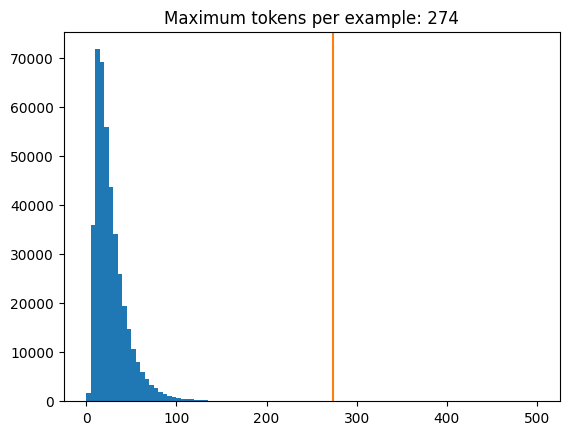

In [46]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [47]:
MAX_TOKENS=128
def prepare_batch(ru, en):
    ru = tokenizers.ru.tokenize(ru)      # Output is ragged.
    ru = ru[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    ru = ru.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (ru, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training.

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples.
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [48]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [49]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset

In [50]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Russian and English sequences, `(ru, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Russian sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Russian, English` sequences.
Given the Russian sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [51]:
for (ru, en), en_labels in train_batches.take(1):
  break

print(ru.shape)
print(en.shape)
print(en_labels.shape)

(64, 109)
(64, 86)
(64, 86)


The `en` and `en_labels` are the same, just shifted by 1:

In [52]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   85   96  144  203   39 1856 1660  236   85], shape=(10,), dtype=int64)
tf.Tensor([  85   96  144  203   39 1856 1660  236   85   96], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [53]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


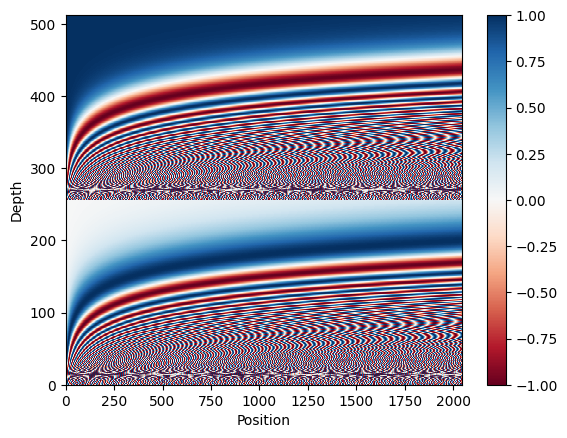

In [54]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

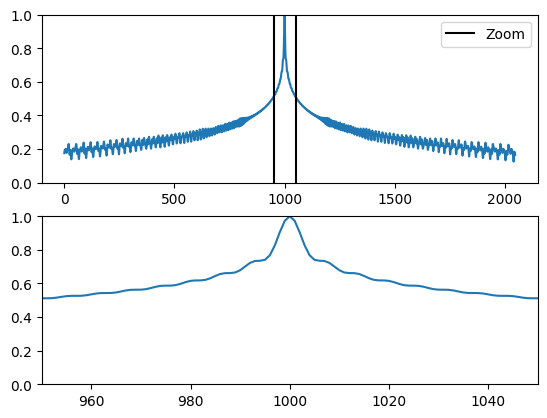

In [55]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [56]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [57]:
embed_ru = PositionalEmbedding(vocab_size=tokenizers.ru.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

ru_emb = embed_ru(ru)
en_emb = embed_en(en)

In [58]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 86), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [59]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [60]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [61]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, ru_emb).shape)

(64, 109, 512)
(64, 86, 512)
(64, 86, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions.

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer:

In [62]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [63]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(sample_gsa(ru_emb).shape)

(64, 109, 512)
(64, 109, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways:

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [64]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [65]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 86, 512)
(64, 86, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [66]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

7.1525574e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions.

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [67]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


Test the layer, the output is the same shape as the input:

In [68]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 86, 512)
(64, 86, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [69]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [70]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(ru_emb.shape)
print(sample_encoder_layer(ru_emb).shape)

(64, 109, 512)
(64, 109, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [71]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [72]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(ru, training=False)

# Print the shape.
print(ru.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 109)
(64, 109, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [73]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [74]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=ru_emb)

print(en_emb.shape)
print(ru_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 86, 512)
(64, 109, 512)
(64, 86, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [75]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [76]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=ru_emb)

# Print the shapes.
print(en.shape)
print(ru_emb.shape)
print(output.shape)

(64, 86)
(64, 109, 512)
(64, 86, 512)


In [77]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 86, 109])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities.

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

In [78]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [79]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [80]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [81]:
output = transformer((ru, en))

print(en.shape)
print(ru.shape)
print(output.shape)

(64, 86)
(64, 109)
(64, 86, 7796)


In [82]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 86, 109)


Print the summary of the model:

In [83]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3641344   
                                                                 
 decoder_1 (Decoder)         multiple                  5747712   
                                                                 
 dense_38 (Dense)            multiple                  1005684   
                                                                 
Total params: 10394740 (39.65 MB)
Trainable params: 10394740 (39.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [84]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [85]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

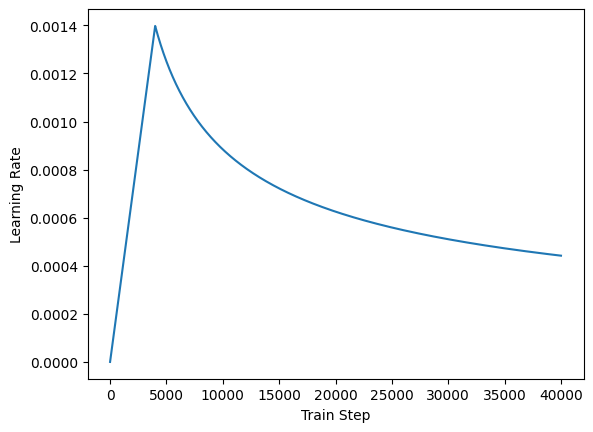

In [86]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [87]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [88]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [89]:
transformer.fit(train_batches,
                epochs=5,
                validation_data=val_batches)

Epoch 1/5
3252/3252 [==============================] - 918s 273ms/step - loss: 4.9023 - masked_accuracy: 0.2608 - val_loss: 3.6803 - val_masked_accuracy: 0.3679
Epoch 2/5
3252/3252 [==============================] - 869s 267ms/step - loss: 3.4378 - masked_accuracy: 0.3917 - val_loss: 2.9746 - val_masked_accuracy: 0.4528
Epoch 3/5
3252/3252 [==============================] - 867s 266ms/step - loss: 2.9440 - masked_accuracy: 0.4484 - val_loss: 2.7085 - val_masked_accuracy: 0.4878
Epoch 4/5
3252/3252 [==============================] - 867s 267ms/step - loss: 2.7140 - masked_accuracy: 0.4777 - val_loss: 2.5691 - val_masked_accuracy: 0.5078
Epoch 5/5
3252/3252 [==============================] - 865s 266ms/step - loss: 2.5738 - masked_accuracy: 0.4967 - val_loss: 2.4832 - val_masked_accuracy: 0.5199


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Russian tokenizer (`tokenizers.ru`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [90]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Russian, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.ru.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [91]:
translator = Translator(tokenizers, transformer)

In [92]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [93]:
sentence = 'это проблема, которую мы должны решить.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : это проблема, которую мы должны решить.
Prediction     : it ' s a problem we have to decide .
Ground truth   : this is a problem we have to solve .


Example 2:

In [94]:
sentence = 'и мои соседи дома услышали об этой идее.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : и мои соседи дома услышали об этой идее.
Prediction     : and my neighbors were hearing about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [95]:
sentence = 'поэтому я просто поделюсь с вами несколькими историями о некоторых волшебных событиях, которые произошли.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : поэтому я просто поделюсь с вами несколькими историями о некоторых волшебных событиях, которые произошли.
Prediction     : so i ' m just going to share with you a few stories about some of the magic events that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [96]:
sentence = 'это первая книга, которую я когда-либо написал.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : это первая книга, которую я когда-либо написал.
Prediction     : this is the first book i ever wrote .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [97]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [98]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 13])

These are the input (Russian) tokens:

In [99]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ru.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(13,), dtype=string, numpy=
array([b'[START]', b'\xd1\x8d\xd1\x82\xd0\xbe',
       b'\xd0\xbf\xd0\xb5\xd1\x80\xd0\xb2\xd0\xb0\xd1\x8f',
       b'\xd0\xba\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb0', b',',
       b'\xd0\xba\xd0\xbe\xd1\x82\xd0\xbe\xd1\x80\xd1\x83\xd1\x8e',
       b'\xd1\x8f', b'\xd0\xba\xd0\xbe\xd0\xb3\xd0\xb4\xd0\xb0', b'-',
       b'\xd0\xbb\xd0\xb8\xd0\xb1\xd0\xbe',
       b'\xd0\xbd\xd0\xb0\xd0\xbf\xd0\xb8\xd1\x81\xd0\xb0\xd0\xbb', b'.',
       b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [100]:
translated_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'ever', b'wrote', b'.', b'[END]'], dtype=object)>

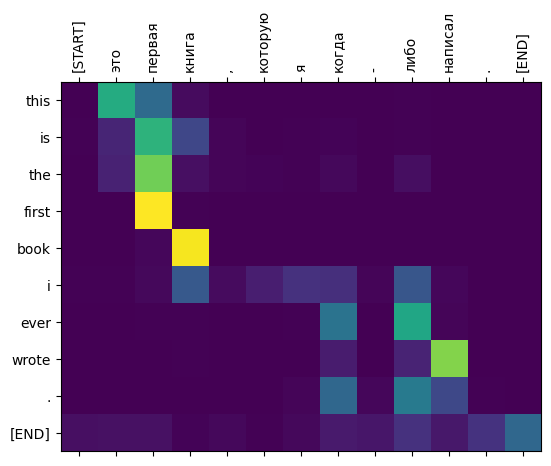

In [101]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [102]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.ru.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

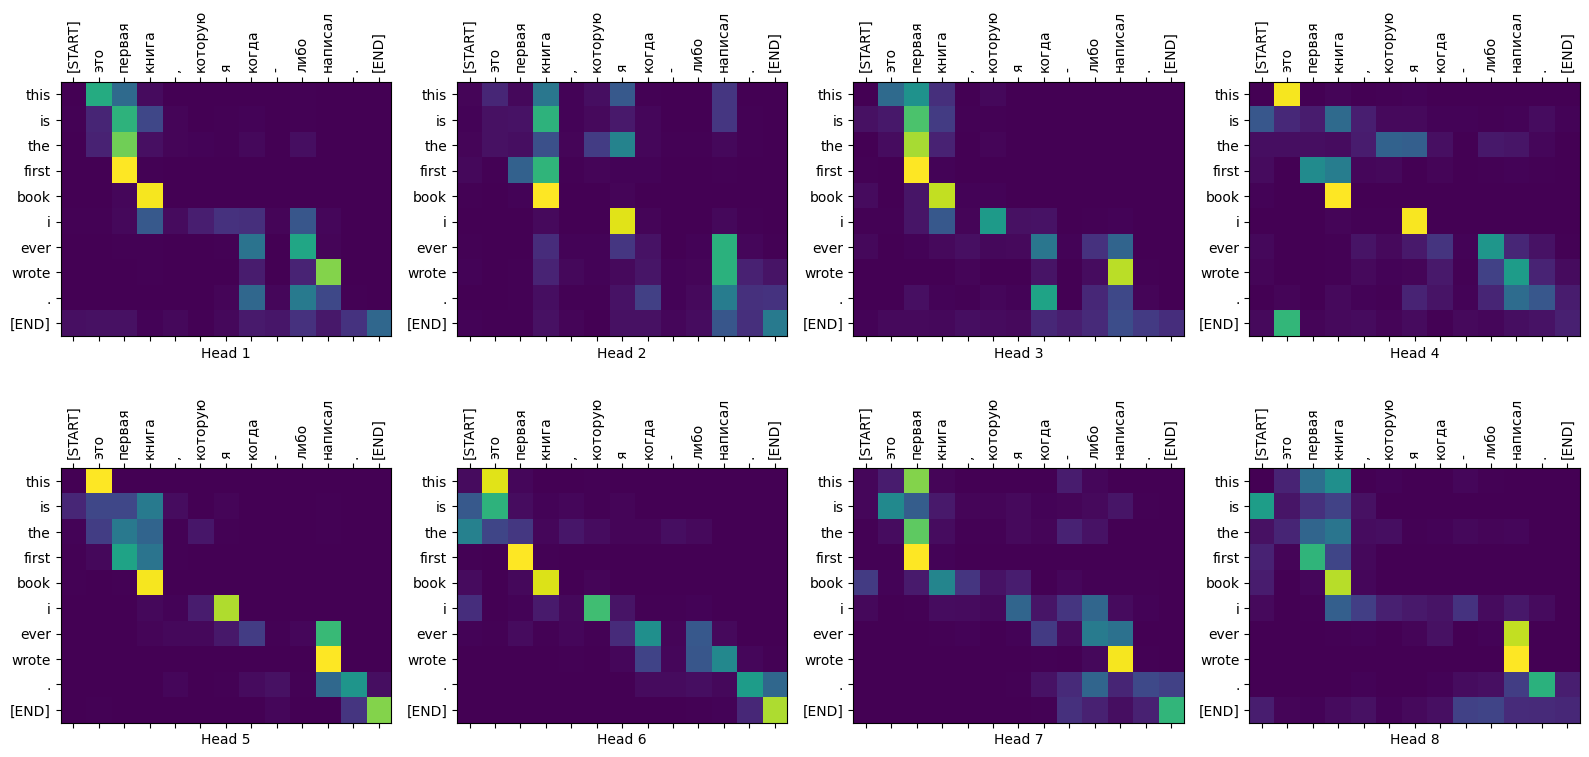

In [103]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Я прочитал о трицератопсе в энциклопедии.
Prediction     : i read about three times perccuasion .
Ground truth   : I read about triceratops in the encyclopedia.


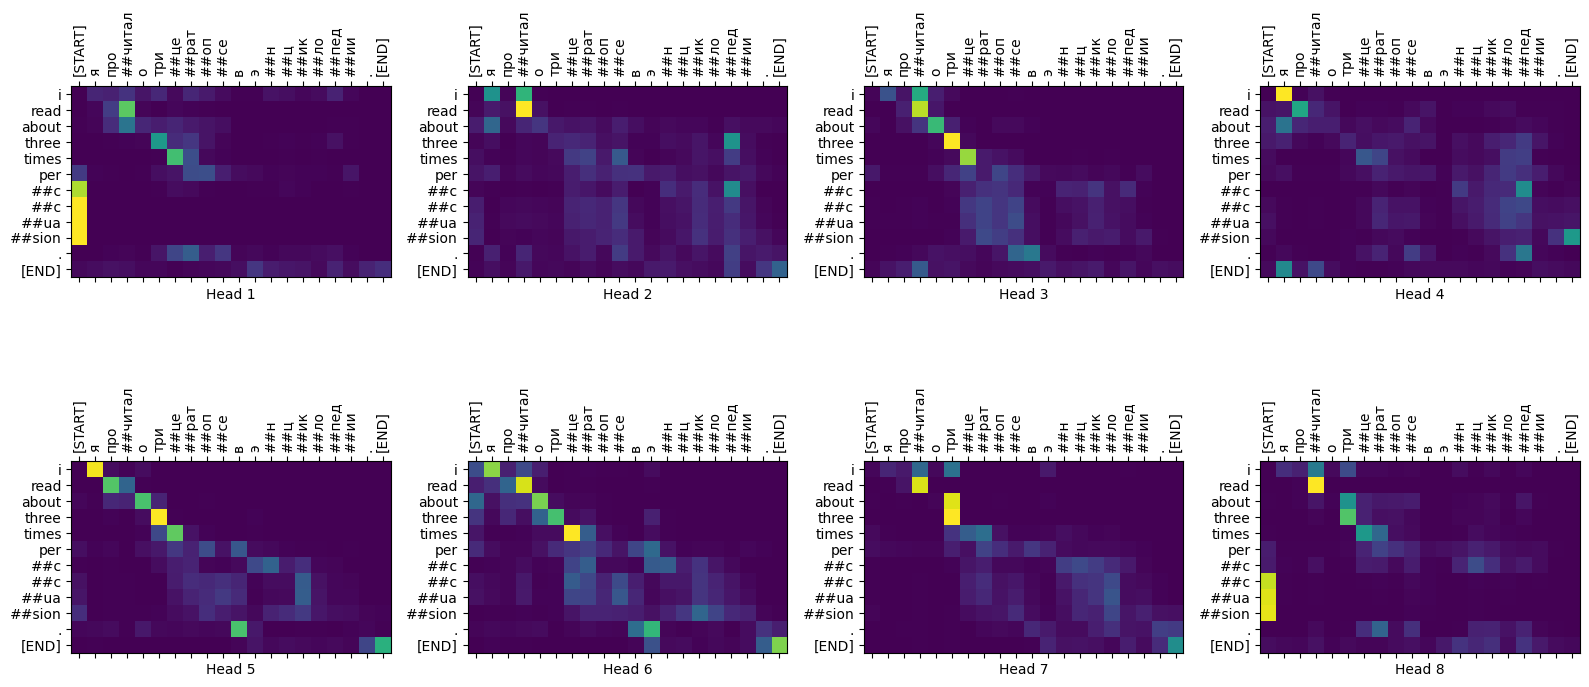

In [104]:
sentence = 'Я прочитал о трицератопсе в энциклопедии.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [105]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [106]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [107]:
translator('Это первая книга, которую я написал.').numpy()

b'this is the first book i wrote .'

In [108]:
tf.saved_model.save(translator, export_dir='translator')

In [109]:
reloaded_model = tf.saved_model.load('translator')

In [110]:
reloaded_model('Это первая книга, которую я написал.').numpy()

b'this is the first book i wrote .'

## Generate test samples

We will use our test batch that we generated before and assign them into our predictions and ground truth

In [111]:
ls_translate=[]
ls_ground_truth=[]

for ru_examples, en_examples in test_examples.batch(1000).take(3):#Getting examples from test
  #print('> Examples in Russian:') #can uncomment this to see the examples generated
  for ru in ru_examples.numpy():
    #print(ru.decode('utf-8')) #can uncomment this to see the examples generated
    ls_translate.append(ru.decode('utf-8'))
  #print()

  #print('> Examples in English:') #can uncomment this to see the examples generated
  for en in en_examples.numpy():
    #print(en.decode('utf-8')) #can uncomment this to see the examples generated
    ls_ground_truth.append(en.decode('utf-8'))

##TO-DO Finish the code

Finish this loop calling our transformer model to call on the translation.


*Hint look at the previous code to understand how the reloaded_model was called.

You should also review the model in general and make sure that you understand all parts of it.

In [112]:
net         = tf.saved_model.load('translator')

for i in range(len(ls_translate)):
    '''
    call the transformer model like in the previous cell
    to perform translation on the ith element of the list ls_translate
    '''
    output      = net(ls_translate[i]).numpy()
    output      = output.decode('utf-8')

    print("Translation: ",output, " Ground Truth: ",ls_ground_truth[i])

Translation:  so it ' s literally more than the sum of its parts .  Ground Truth:  so the whole is literally more than the sum of its parts .
Translation:  ` ` and i would like to close with the old poems of shofi , ` ` ' ' come to surprise us , let ' s be friends , and we ' re going to be able to be friends , and we love to be loved , and the earth does n ' t have to get . ' '  Ground Truth:  `` and i would like to finish with an old sufi poem : `` '' come , let us be friends for once ; let us make life easy on us ; let us be lovers and loved ones ; the earth shall be left to no one . '' '' thank you . ''
Translation:  and even though she was offered a job in another company , and she was trying to try to try to try and try to try and find her happiness at the time and hope .  Ground Truth:  so even though she had a second job offer at another company for a permanent full-time role , she decided to take her chances with this internship and hope for the best .
Translation:  ( laughter 

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
